In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm
from scipy.special import erf
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from scipy.stats import multivariate_normal,kstest,norm,t
from scipy.interpolate import interp1d
from scipy.special import erf
from joblib import Parallel, delayed
from scipy.optimize import minimize
from statsmodels.distributions.empirical_distribution import ECDF
from pandas.tseries.offsets import Day, BDay
from datetime import date
import matplotlib.ticker as mtick
#from pypfopt_risk_models import *
import os
import h5py
from joblib import wrap_non_picklable_objects
from hmmlearn import hmm
Ncores=6
#plt.style.use('stylesheet')
plt.style.use('/home/luuk/Documents/MNRAS_stylesheet')

In [45]:
# Helper functions
# Gaussian PDF
def gauss_pdf(x, mu,var):
    sigma = np.sqrt(var)
    return norm(scale=sigma, loc=mu).pdf(x)

# Gaussian CDF
def gauss_cdf(x,mu,sigma):
    return 0.5*(1+erf((x-mu)/(sigma*np.sqrt(2))))

def gauss_icdf(x,mu,sigma):
    return norm.ppf(x,loc=mu,scale=sigma)


def KS_test(returns, cdf1, cdf2):
    p1 = kstest(returns, cdf1)[1]
    p2 = kstest(returns, cdf2)[1]
    return p1,p2

def load_timeseries():
    # Get filenames using glob
    fnames = glob('./timeseries/*csv')
    for f in fnames:
        newdf = pd.read_csv(f)[['Date','Close']]
        newdf = newdf.set_index('Date')
        newdf.index = pd.to_datetime(newdf.index)
        newdf.columns = [f.split('/')[-1].split('.csv')[0]]
        try:
            df = df.join(newdf)
        except:
            df = newdf
    df = df.dropna()
    return df

def plot_timeseries():
    # First plot of all timeseries
    (df / df.iloc[0]*100).plot(lw=1)
    plt.legend(frameon=1)
    plt.ylabel('Normalized stock index price')
    plt.tight_layout()
    plt.savefig('Prices.pdf',bbox_inches='tight')
    
# VaR estimation using variance-covariance matrix
class dataconversion():
    def __init__(self):
        return
    
    def to_log_ret(self, df):
        """Convert prices to log returns"""
        log_ret = np.log(df/df.shift(1))
        return log_ret.iloc[1:,:]
    
def qq_plot():
    
    def order(data, sample_size):
        qq = np.ones([sample_size, 2])
        np.random.shuffle(data)
        qq[:, 0] = np.sort(data[0:sample_size])
        qq[:, 1] = np.sort(np.random.normal(size = sample_size))
        return qq
    
    for stock in stocks:
        measurements = returns[stock]
        qq = order(measurements/np.std(measurements), len(measurements))
        plt.scatter(qq[:,1],qq[:,0],s=0.8,label=stock)
    plt.xlabel('Theoretical quantiles')    
    plt.ylabel('Sample quantiles')
    plt.legend(frameon=1)
    plt.plot([-4,4],[-4,4],color='black',lw=0.5,ls='--')
    plt.tight_layout()
    plt.savefig('qq_plot.pdf',bbox_inches='tight')
    plt.show()
    
def CDFs():
    # Plot CDFs to check normality
    fig,axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=(6,3.4))
    axes = axes.flatten()
    for i,stock in enumerate(stocks):
        empirical_CDF = ECDF(returns[stock])
        ax = axes[i]
        ax.plot(empirical_CDF.x,empirical_CDF.y,lw=1,color='tomato',label='ECDF')
        x = np.linspace(empirical_CDF.x[1],empirical_CDF.x[-2], 1000)
        fitted_cdf = gauss_cdf(x, model.means_[0,i], np.sqrt(model.covars_[0,i,i]))
        ax.plot(x, fitted_cdf,color='black',lw=0.7,ls='--',label=r'$\mathcal{N}$-CDF')
        ax.set_xlim(-0.07,0.07)
        ax.legend(frameon=1)
    for i in [3,4,5]:
        axes[i].set_xlabel('Return')
    for i in [0,3]:
        axes[i].set_ylabel('CDF')
    plt.tight_layout()
    plt.savefig('CDF_comparison.pdf', bbox_inches='tight')
    plt.show()


In [54]:
df = load_timeseries()

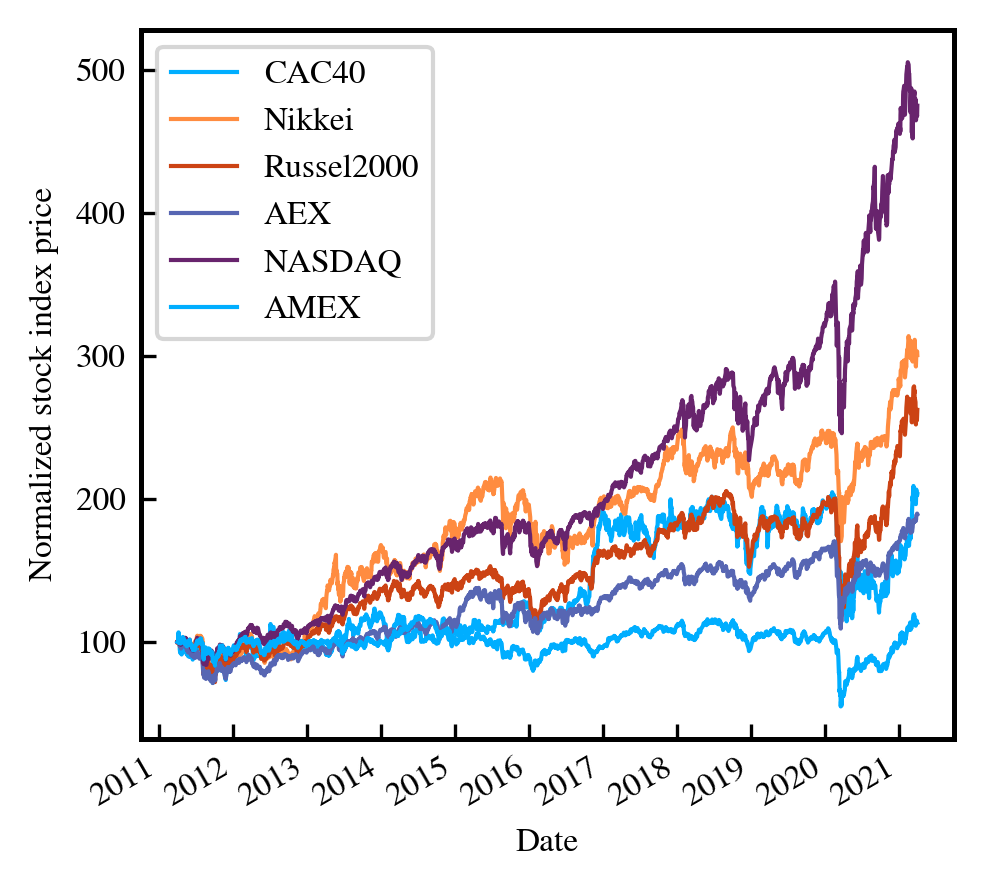

In [55]:
plot_timeseries()

In [27]:
# Convert prices to log returns
DC = dataconversion()
returns = DC.to_log_ret(df)
stocks = df.columns

In [9]:
from hmmlearn import hmm
model = hmm.GaussianHMM(n_components=1, covariance_type="full")
model.fit(returns)

GaussianHMM(covariance_type='full')

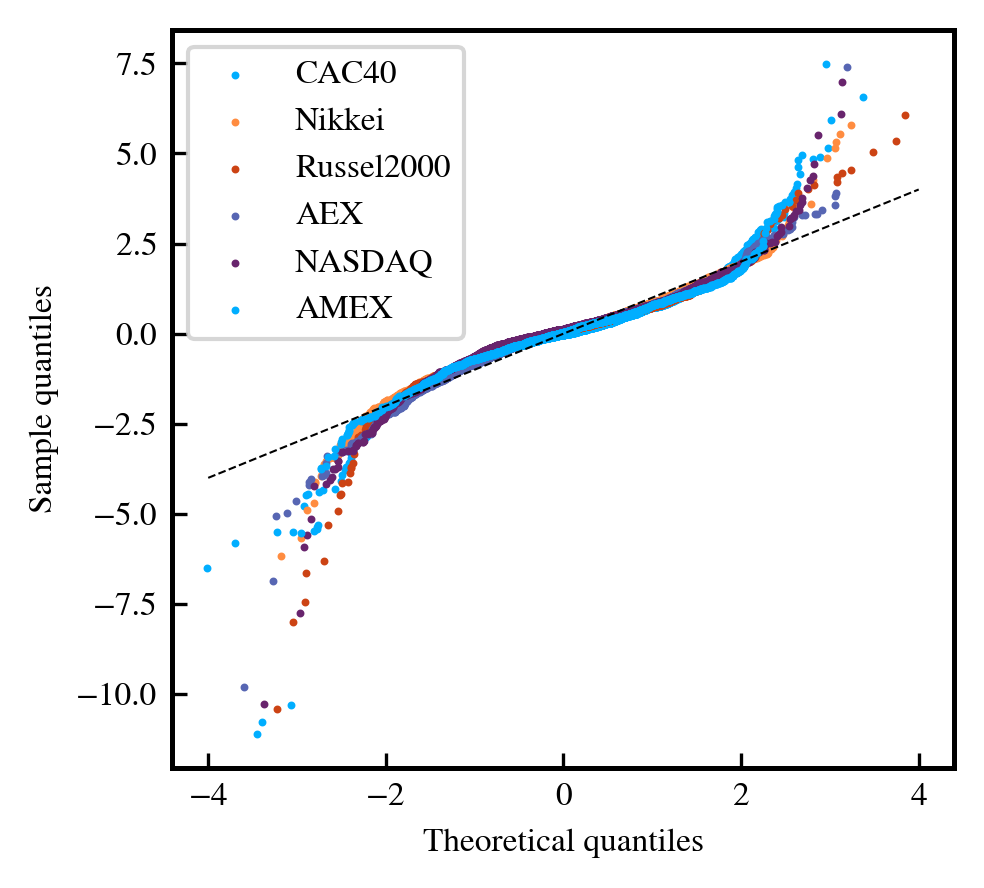

In [10]:
qq_plot()

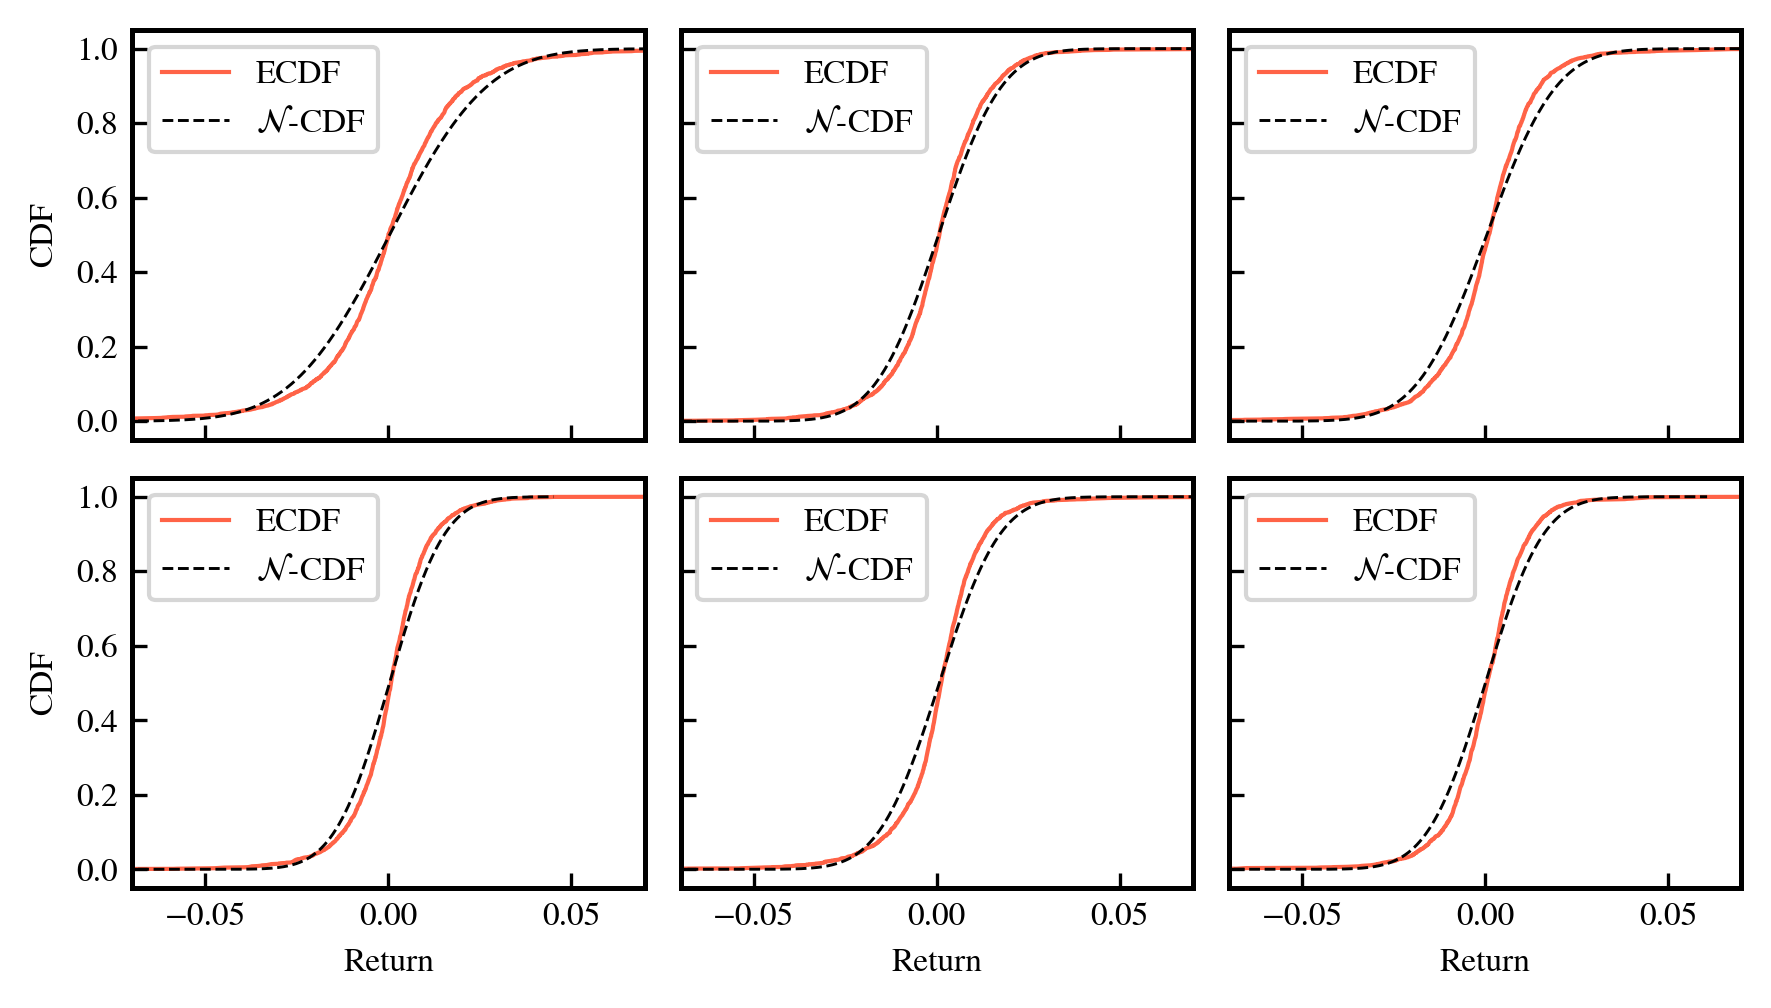

In [11]:
CDFs()

In [12]:
# Estimate covariance matrix
# Option 1: normal covariance matrix
covmat1 = returns.cov()
# Option 2: Ledoit Wolf shrinkage
from sklearn.covariance import LedoitWolf
covmat2 = LedoitWolf().fit(returns)
covmat2 = pd.DataFrame(covmat2.covariance_,index=covmat1.index, columns = covmat1.columns)

In [13]:
# Estimate covariance matrix over first two years
init_covmat = returns.loc[:'2013-03'].cov()
covmats = np.zeros((1+len(returns.loc['2013-03':]), len(stocks), len(stocks)))
covmats[0,:,:] = init_covmat
# Iteratively update covmat
theta=0.04
for i,(date, X) in enumerate(returns.loc['2013-03':].iterrows()):
    X = X.values
    X = X - returns.mean().values
    X = X.reshape(-1,1)
    covmats[i+1] = theta * covmats[i] + (1-theta) * np.dot(X,X.T)

In [14]:
# Now estimate VaR 
alpha = 0.01
sigmas = np.array([np.sqrt(np.diag(covmats[w,:,:])) for w in range(len(covmats))])
VaR = +returns.mean().values + norm.ppf(1-alpha)*sigmas
ES  = +returns.mean().values + 1/alpha * norm.pdf(norm.ppf(alpha))*sigmas

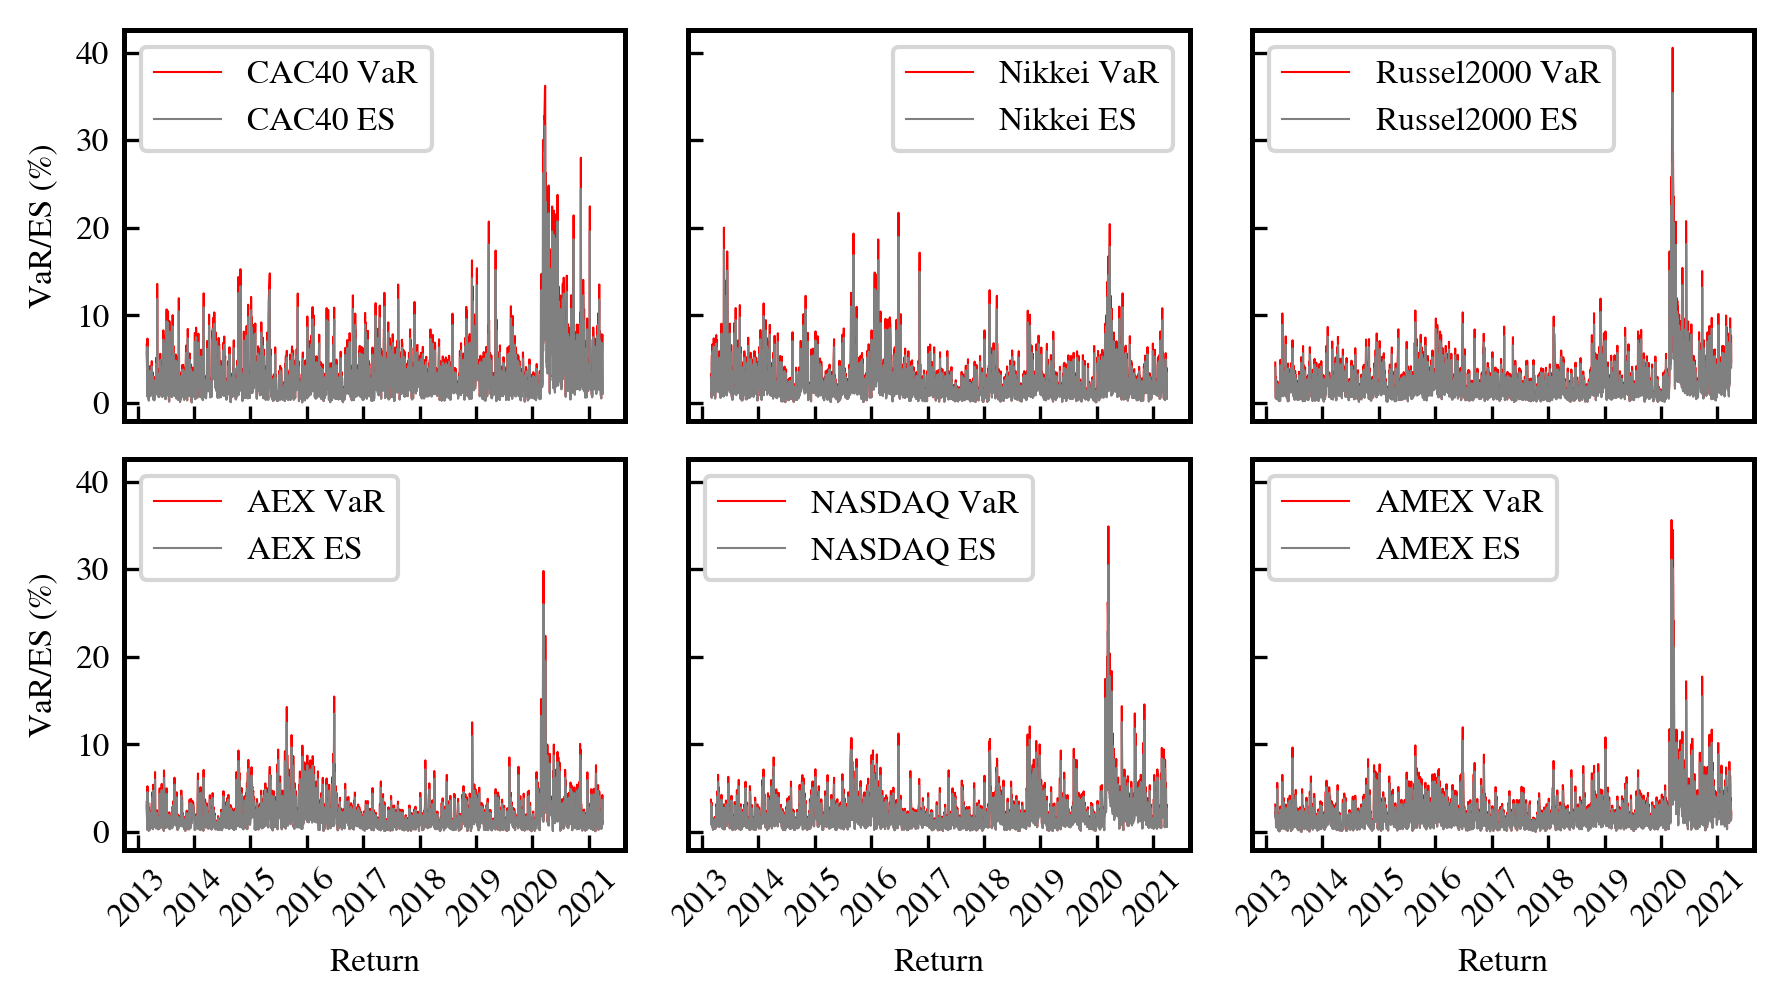

In [15]:
# Plot CDFs to check normality
fig,axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=(6,3.4))
axes = axes.flatten()
for i,stock in enumerate(stocks):
    var = VaR[:-1,i]*100
    es  = ES[:-1,i]*100
    ax = axes[i]
    ax.plot(returns.loc['2013-03':].index, es,lw=0.5,color='red',label=stock+' VaR')
    ax.plot(returns.loc['2013-03':].index, var,lw=0.5,color='grey',label=stock+' ES')
    
    ax.legend(frameon=1)
    
for i in [3,4,5]:
    axes[i].set_xlabel('Return')
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45 )
for i in [0,3]:
    axes[i].set_ylabel('VaR/ES (%)')
plt.tight_layout()
plt.savefig('ES_VaR_covariance.pdf', bbox_inches='tight')
plt.show()

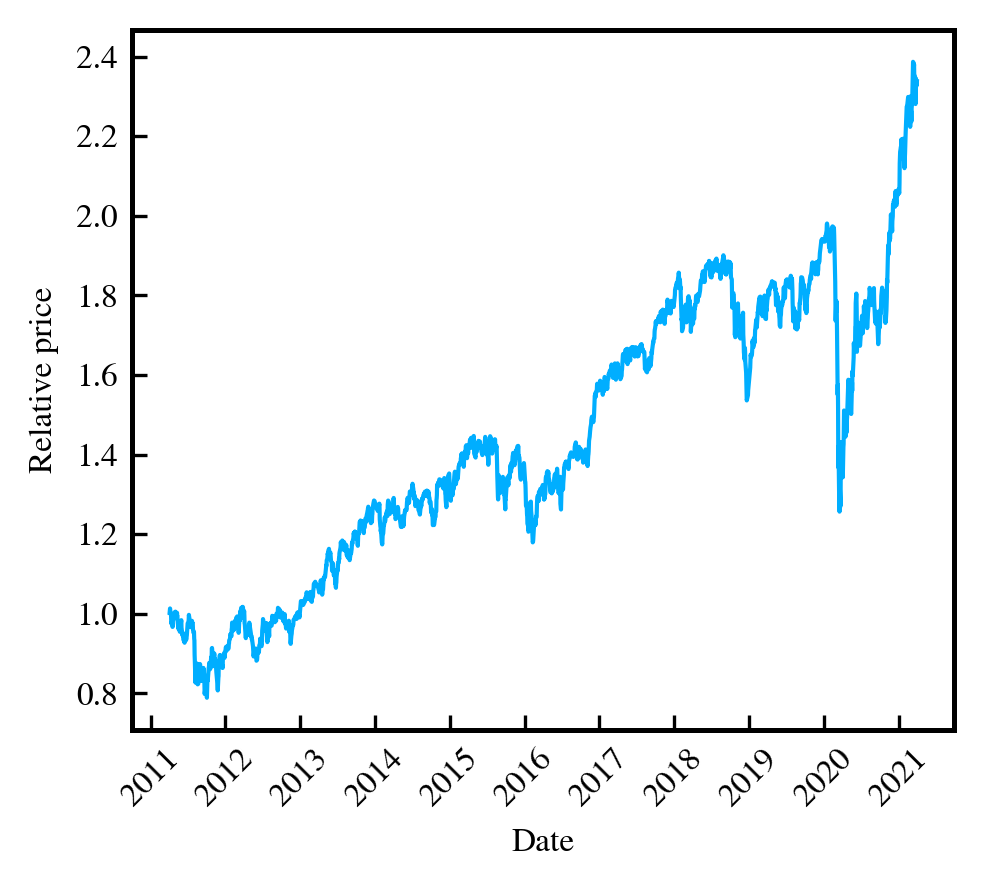

In [16]:
# We can also consider a portfolio of all six indices
weights = np.ones(6)/6
portfolio = np.dot(weights, returns.T)
plt.plot(returns.index,np.exp(np.cumsum(portfolio)),lw=1)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Relative price')
plt.tight_layout()
plt.savefig('price_equal_portfolio.pdf',bbox_inches='tight')

In [17]:
# Portfolio variance is given by 
port_var = lambda w,Omega: np.dot(np.dot(w.T, Omega), w)
# We can again iteratively determine this for the portfolio
portfolio_variance = np.array([port_var(weights, covmats[w]) for w in range(len(covmats))])
# Convert variance to VaR 
VaR = np.sqrt(portfolio_variance) * norm.ppf(1-alpha) + np.dot(weights, returns.mean())
ES = np.sqrt(portfolio_variance) * 1/alpha * norm.pdf(norm.ppf(alpha)) + np.dot(weights, returns.mean())

VaR = pd.Series(100*VaR[:-1], index=returns.loc['2013-03':].index)
ES  = pd.Series(100*ES[:-1], index=returns.loc['2013-03':].index)

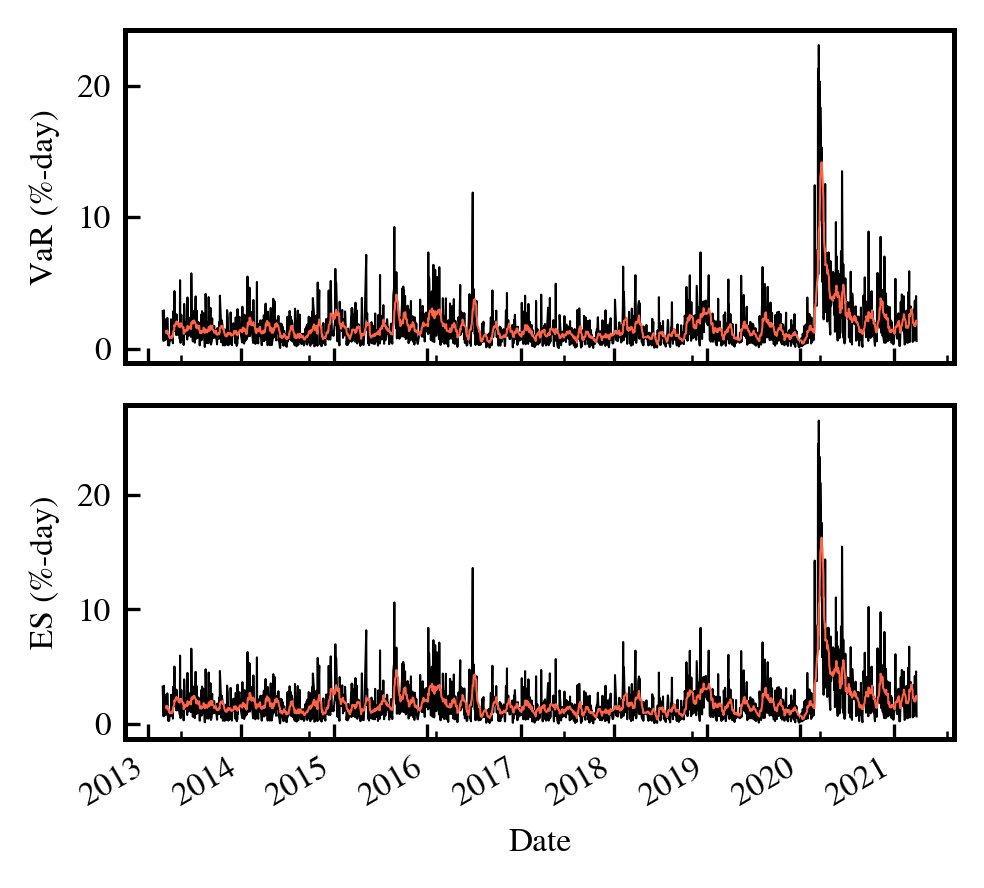

In [18]:
fig, axes = plt.subplots(nrows=2,sharex=True)
axes[0].plot(VaR.index, VaR.values,lw=0.5,color='black')
VaR.rolling(10).mean().plot(ax=axes[0],lw=0.5,color='tomato')
axes[1].plot(ES.index, ES.values,lw=0.5,color='black')
ES.rolling(10).mean().plot(ax=axes[1],lw=0.5,color='tomato')
axes[0].set_ylabel('VaR (%-day)')
axes[1].set_ylabel('ES (%-day)')
plt.tight_layout()
plt.savefig('Portfolio_VaR_ES.pdf', bbox_inches='tight')

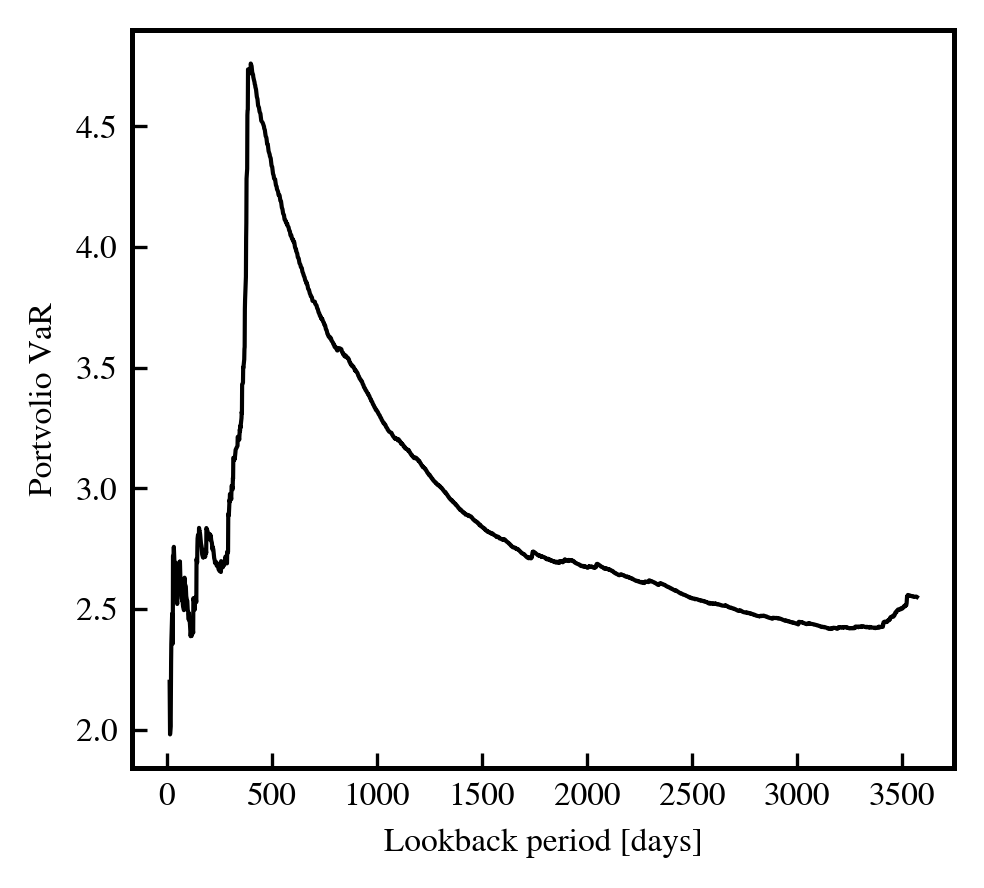

In [19]:
# We can also do a static VaR estimation based on different amounts of history
VaRs = []
lookbacks = []
for startdate in returns.index[:-10]:
    # Get subdf
    subdf = returns.loc[startdate:]
    # Get covariance matrix and mean
    sub_covmat = subdf.cov()
    sub_means  = subdf.mean()
    VaR = np.sqrt(port_var(weights, sub_covmat))* norm.ppf(1-alpha) + np.dot(weights, sub_means)
    VaRs.append(100*VaR)
    lookbacks.append((returns.index[-1] - startdate).days)
plt.plot(lookbacks[50:], VaRs[50:],lw=1,color='black')
plt.xlabel('Lookback period [days]')
plt.ylabel('Portvolio VaR')
plt.tight_layout()
plt.savefig('Portfolio_VaR_lookbackperiod.pdf', bbox_inches='tight')

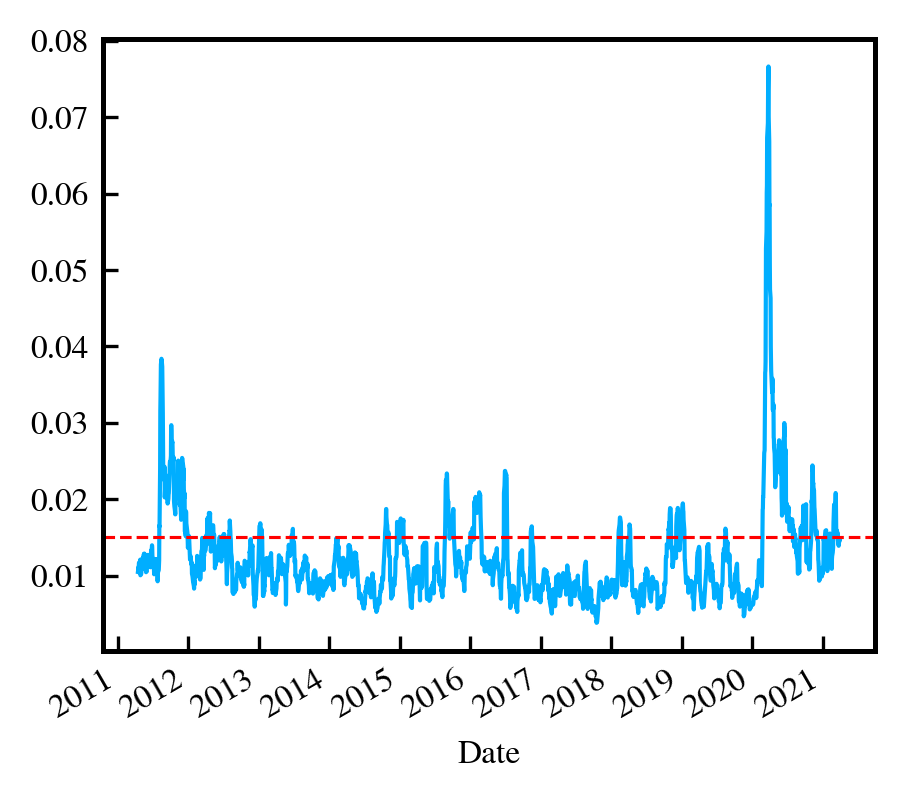

0.04225352112676056
0.014084507042253521


In [20]:
# Backtesting
# We can also do a static VaR estimation based on different amounts of history
returns.rolling(10).std().mean(axis=1).plot(lw=1)
plt.axhline(0.015,ls='--',color='red',lw=0.75)
returns_wo_stress = returns[returns.rolling(10).std().mean(axis=1)<0.015]
portfolio_variance1 = port_var(weights, returns_wo_stress.cov())
portfolio_variance2 = port_var(weights, returns.cov())
VaR1 = np.sqrt(portfolio_variance1) * norm.ppf(1-alpha) + np.dot(weights, returns_wo_stress.mean())
VaR2 = np.sqrt(portfolio_variance2) * norm.ppf(1-alpha) + np.dot(weights, returns.mean())
plt.show()

# Backtest:
portfolio_returns = np.dot(weights, returns.T)
print(np.mean(portfolio_returns < -VaR1))
print(np.mean(portfolio_returns < -VaR2))

In [33]:
returns.columns

Index(['CAC40', 'Nikkei', 'Russel2000', 'AEX', 'NASDAQ', 'AMEX'], dtype='object')

/home/luuk/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000433. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/luuk/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001794. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/luuk/anaconda3/lib/python3.8/site-packages/arch/univariate/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6115.543692444821
            Iterations: 9
            Function evaluations: 77
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6990.522534308604
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7034.168777351097
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7442.721683574129
            Iterations: 2
            Function evaluations: 29
            Gradient evaluations: 2


/home/luuk/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001644. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/luuk/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001505. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Optimization terminated successfully    (Exit mode 0)
            Current function value: -7323.426472110887
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7398.799114878435
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2


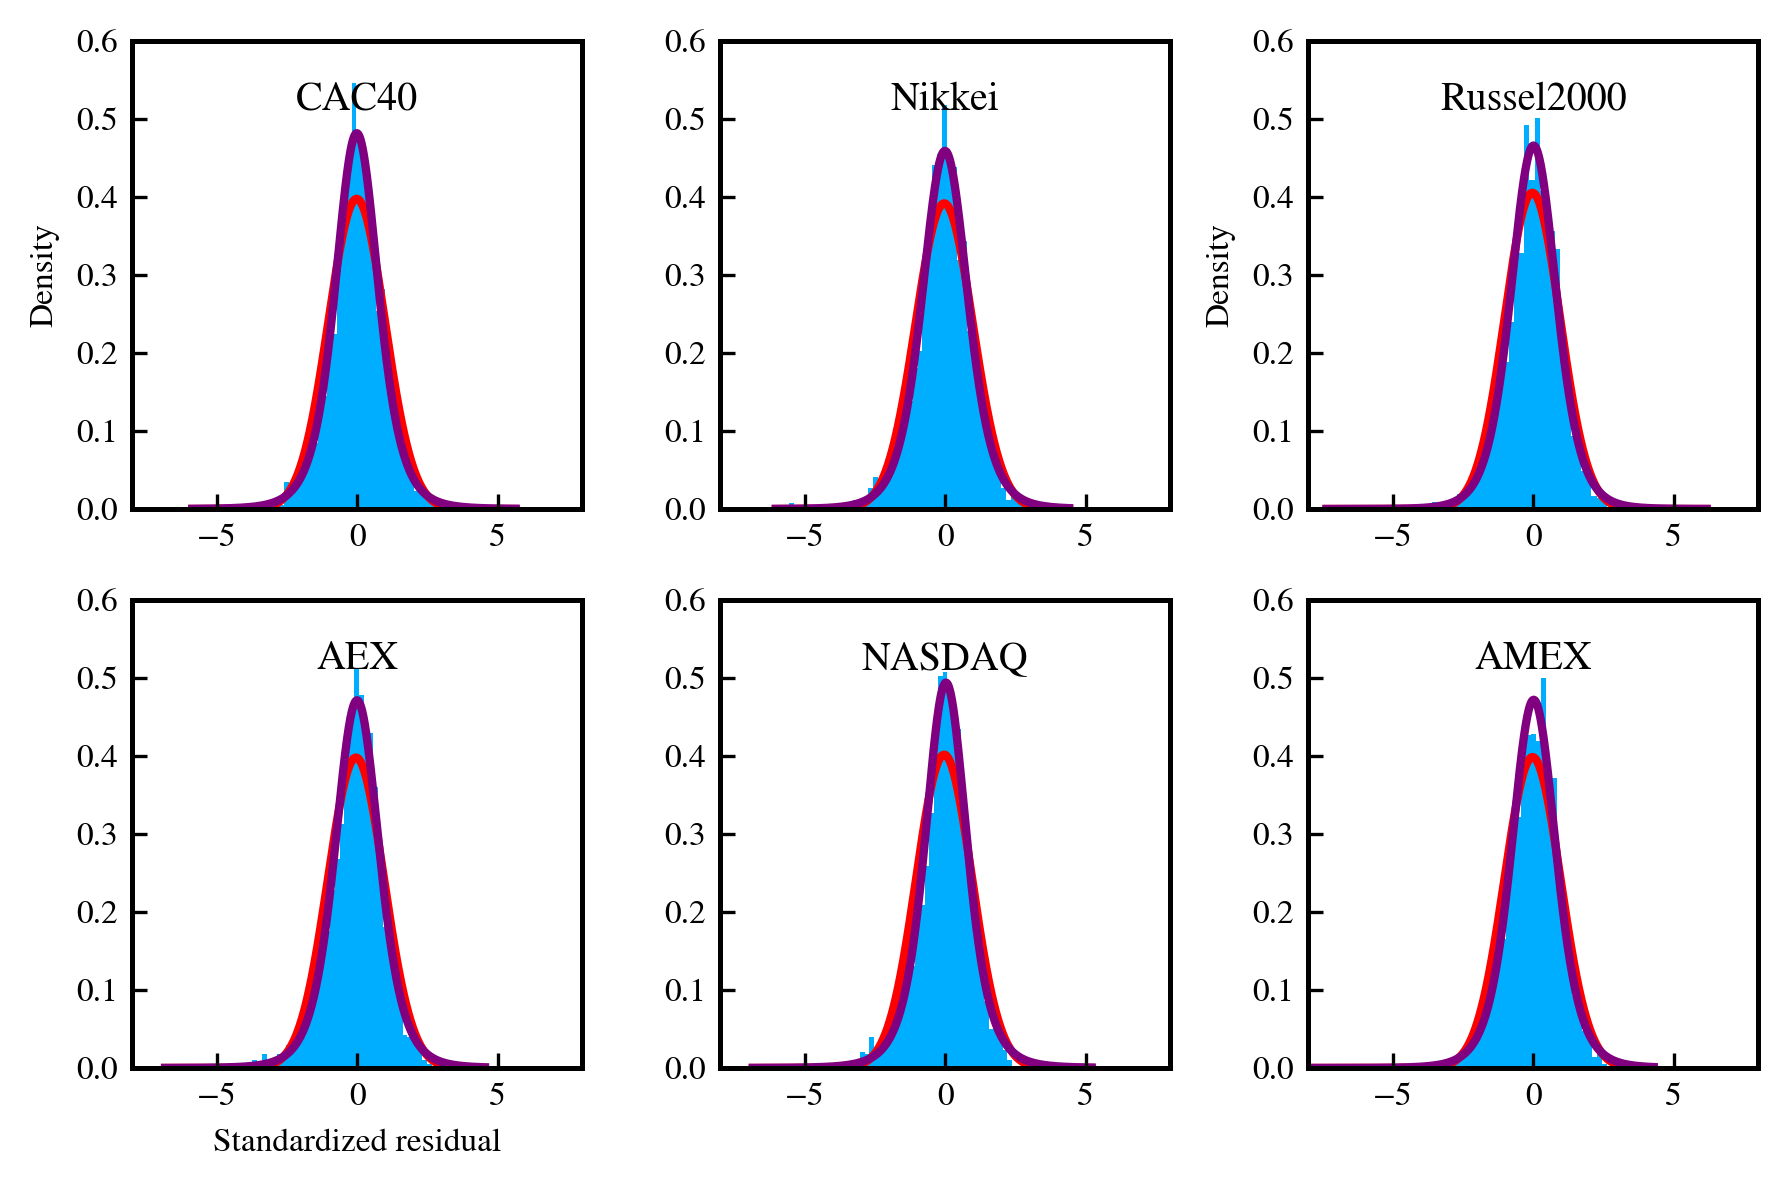

In [79]:
# Filtered historic simulation
from arch import arch_model
fig,axes = plt.subplots(2,3,figsize=(6,4))
axes=axes.flatten()
residuals    = pd.DataFrame(index=returns.index)
volatilities = pd.DataFrame(index=returns.index)
for i,asset in enumerate(returns.columns):
    ret = returns[asset].dropna()
    # Check trailing zeros
    ret[(ret==0).rolling(5).sum() == 5]=np.nan
    ret = ret.iloc[5:].dropna()
    dates = ret.index
    ret = ret.values.flatten()
    # Scaling to improve GARCH estimation
    C = 4
    #ret = ret * 10**C
    # Fit constant mean GARCH(1,1) model
    am = arch_model(ret, p=1,q=1)
    res = am.fit(update_freq=0,)
    # Get conditional volatilities
    volas = res.conditional_volatility
    # Estimate empirical distribution of zt
    zt = (ret-res.params.mu) / volas
    axes[i].hist(zt,density=True)
    axes[i].set_title(returns.columns[i], y=0.8)
    mu,sigma = norm.fit(zt)
    x = np.linspace(*axes[i].get_xlim(),1000)
    # Normal
    axes[i].plot(x, norm(*norm.fit(zt)).pdf(x),color='red')
    # t distr
    axes[i].plot(x, t(*t.fit(zt)).pdf(x),color='purple')
    # GMM
    #gmm=GaussianMixture(3)
    #gmm.fit(zt.reshape(-1,1))
    #axes[i].plot(x,np.exp(gmm.score_samples(x.reshape(-1,1))),color='green')
    residuals.loc[dates,asset] = zt
    volatilities.loc[dates,asset] = volas
    axes[i].set_ylim(0,0.6)
    axes[i].set_xlim(-8,8)
for i in range(3,4,5):
    axes[i].set_xlabel('Standardized residual')
for i in [0,2]:
    axes[i].set_ylabel('Density')
plt.tight_layout()
plt.savefig('GARCH_residuals.pdf',dpi=500)

In [81]:
# We can now use the empirical residuals from the estimated GARCH model to simulate including historic simulations
residuals = residuals.dropna()
# Mean volatilities
volatilities.mean()*np.sqrt(252)*100

CAC40         30.008203
Nikkei        19.990068
Russel2000    20.795412
AEX           16.949495
NASDAQ        18.194834
AMEX          17.356454
dtype: float64

In [63]:
# We now keep the volatilities at the mean and simulate reps 5 and 10 year of historic paths

In [94]:
np.percentile(np.dot(weights,(residuals*volatilities.mean()).T),5)

-0.016017081046649066